# Enable observability for PaLM 2

This accelerator aims to show how you can easily enable observability in your <a href='https://ai.google/discover/palm2/'>PaLM 2</a>-based generative AI Solutions using DataRobot's LLMOps feature tools. To make the notebook more accessible, the accelerator includes an example of a byte-sized solution in its current state. The accelerator then uses DataRobot's tools to enable observability almost instantly for the solution. DataRobot provides tools to enable observability of external henerative models effortlessly. All the hallmarks of DataRobot MLOps are now available for LLMOPs.

## Setup

### Install the pre-requisite libraries

In [1]:
!pip install datarobotx[llm] datarobot-mlops datarobot-mlops-connected-client transformers "langchain==0.0.335"

In [2]:
!pip install google-api-python-client google-auth-httplib2 google-auth-oauthlib google-cloud-aiplatform vertexai google-api-core[grpc,grpcgcp]

In [3]:
!pip install py-readability-metrics nltk

### Import a PaLM 2 model

The cell below outlines the current state of PaLM 2-based text generation model implementation. The example uses the PaLM 2 model from GCP to generate text. The `get_completion` endpoint is used to generate text based on the input prompt. To enable observability for this implementation, you would have to write a lot of code to take measurements, enable infrastructure to record all the measurements, and codify rules for interventions. This introduces a lot of technical debt in your organization. 

In [4]:
from google.oauth2 import service_account
import vertexai
from vertexai.language_models import TextGenerationModel

credentials = service_account.Credentials.from_service_account_file(
    "./storage/datarobot-vertex-pipelines-999cb96585e1.json"
)
vertexai.init(
    project="datarobot-vertex-pipelines",
    location="us-central1",
    credentials=credentials,
)
parameters = {"temperature": 0.2, "max_output_tokens": 1024, "top_p": 0.8, "top_k": 1}
model = TextGenerationModel.from_pretrained("text-bison@001")


def get_completion(prompt, **parameters):
    return model.predict(prompt, **parameters)


prompt = """explain agile scrum to me like I am a 5 year old"""
get_completion(prompt, **parameters)

Agile scrum is a way of working that helps teams get things done. It's like when you and your friends work together to build a fort in the living room.
First, you need to decide what you want to build. Then, you break the project down into smaller tasks that you can each do. Once you have a plan, you start working on your tasks. As you work, you check in with each other to make sure you're on track. If something changes, you adjust your plan and keep going.
Agile scrum is all about teamwork, communication, and flexibility. It's a great way to get things done, even if they're big and complicated.

## Observability with DataRobot

To enable observability on the above PaLM 2 implementation, you first need to create a deployment in DataRobot. This can be done from the GUI or API as per user preference.

In [ ]:
# Initialize the DataRobot Client if you are not running this code on DataRobot platform.
# import datarobot as dr
# dr.Client(<config>)

In [6]:
from utilities import create_external_llm_deployment

deployment_id, model_id = create_external_llm_deployment("PaLM 2 External")

[nltk_data] Downloading package punkt to /home/notebooks/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Start monitoring configuration

The cell below declares and initializes the monitoring configuration. The <a href='https://drx.datarobot.com/reference/_autosummary/datarobotx.llm.MonitoringConfig.html#monitoringconfig'>monitoring configuration</a> lets DataRobot understand how to interpret the inputs and outputs of the external model. Standard implementation of the hosted PaLM 2(codename:text-bison@001) has a predict endpoint which expects prompt text and other parameters which are configured in the <a href='https://drx.datarobot.com/reference/_autosummary/datarobotx.llm.MonitoringConfig.html#monitoringconfig'>MonitoringConfig</a> object as seen below.

In [ ]:
from datarobotx.llm.chains.guard import aguard, MonitoringConfig

monitor_config = MonitoringConfig(
    deployment_id=deployment_id,
    model_id=model_id,
    inputs_parser=lambda prompt, **parameters: {**{"prompt": prompt}, **parameters},
    output_parser=lambda x: {"completion": str(x.text)},
    target="completion",
)

Once the configuration is defined, wrap the original completion function with the decorator and DataRobot will start monitoring the generative model. With just a few lines of code, you have enabled full-fledged observability on an external generative model in a few minutes.

In [8]:
@aguard(monitor_config)
async def get_completion_cm(prompt, **parameters):
    response = TextGenerationModel.from_pretrained("text-bison@001").predict(prompt, **parameters)
    return response


prompt = """explain agile scrum to me like I am a 5 year old"""
await get_completion_cm(prompt, **parameters)

Agile scrum is a way of working that helps teams get things done. It's like when you and your friends work together to build a fort in the living room.
First, you need to decide what you want to build. Then, you break the project down into smaller tasks that you can each do. Once you have a plan, you start working on your tasks. As you work, you check in with each other to make sure you're on track. If something changes, you adjust your plan and keep going.
Agile scrum is all about teamwork, communication, and flexibility. It's a great way to get things done, even if they're big and complicated.

## Custom metrics

Observability with DataRobot also supports <a href='https://app.datarobot.com/docs/mlops/deployment-settings/custom-metrics-settings.html'>custom user metrics</a>. In the following cells show how you can start capturing toxicity in user prompts and readability in generative model responses. Add the custom metrics in the following cell to record them in your deployment. This step can be done easily using DataRobt's GUI or API based on your preference. <br>
- Toxicity in the user prompt <br>
- Readability (Flesch Score) of the model response 

In [ ]:
from utilities import create_custom_metric

TOX_CUSTOM_METRIC_ID = create_custom_metric(
    deployment_id=deployment_id,
    name="Prompt Toxicity",
    baseline="0.1",
    type="average",
    directionality="lowerIsBetter",
)

READ_CUSTOM_METRIC_ID = create_custom_metric(
    deployment_id=deployment_id,
    name="Response Readability",
    baseline="30",
    type="average",
    directionality="higherIsBetter",
)

### Update the PaLM 2 completion

Modify the prediction function to add code that calculates the custom metrics and submit them to the deployment. Now, whenever the prediction is requested from the PaLM 2 model, the metrics are calculated and submitted on the deployment, enabling the users to monitor and intervene as necessary.

In [10]:
from utilities import get_flesch_score, get_text_texicity, submit_custom_metric


@aguard(monitor_config)
async def get_completion_cm(prompt, **parameters):
    response = TextGenerationModel.from_pretrained("text-bison@001").predict(prompt, **parameters)
    try:
        submit_custom_metric(deployment_id, READ_CUSTOM_METRIC_ID, get_flesch_score(response.text))
        submit_custom_metric(deployment_id, TOX_CUSTOM_METRIC_ID, get_text_texicity(prompt))
    except Exception as e:
        print(e)
        pass
    return response


prompt = """explain agile scrum to me like I am a 5 year old"""
await get_completion_cm(prompt, **parameters)

Agile scrum is a way of working that helps teams get things done. It's like when you and your friends work together to build a fort in the living room.
First, you need to decide what you want to build. Then, you break the project down into smaller tasks that you can each do. Once you have a plan, you start working on your tasks. As you work, you check in with each other to make sure you're on track. If something changes, you adjust your plan and keep going.
Agile scrum is all about teamwork, communication, and flexibility. It's a great way to get things done, even if they're big and complicated.

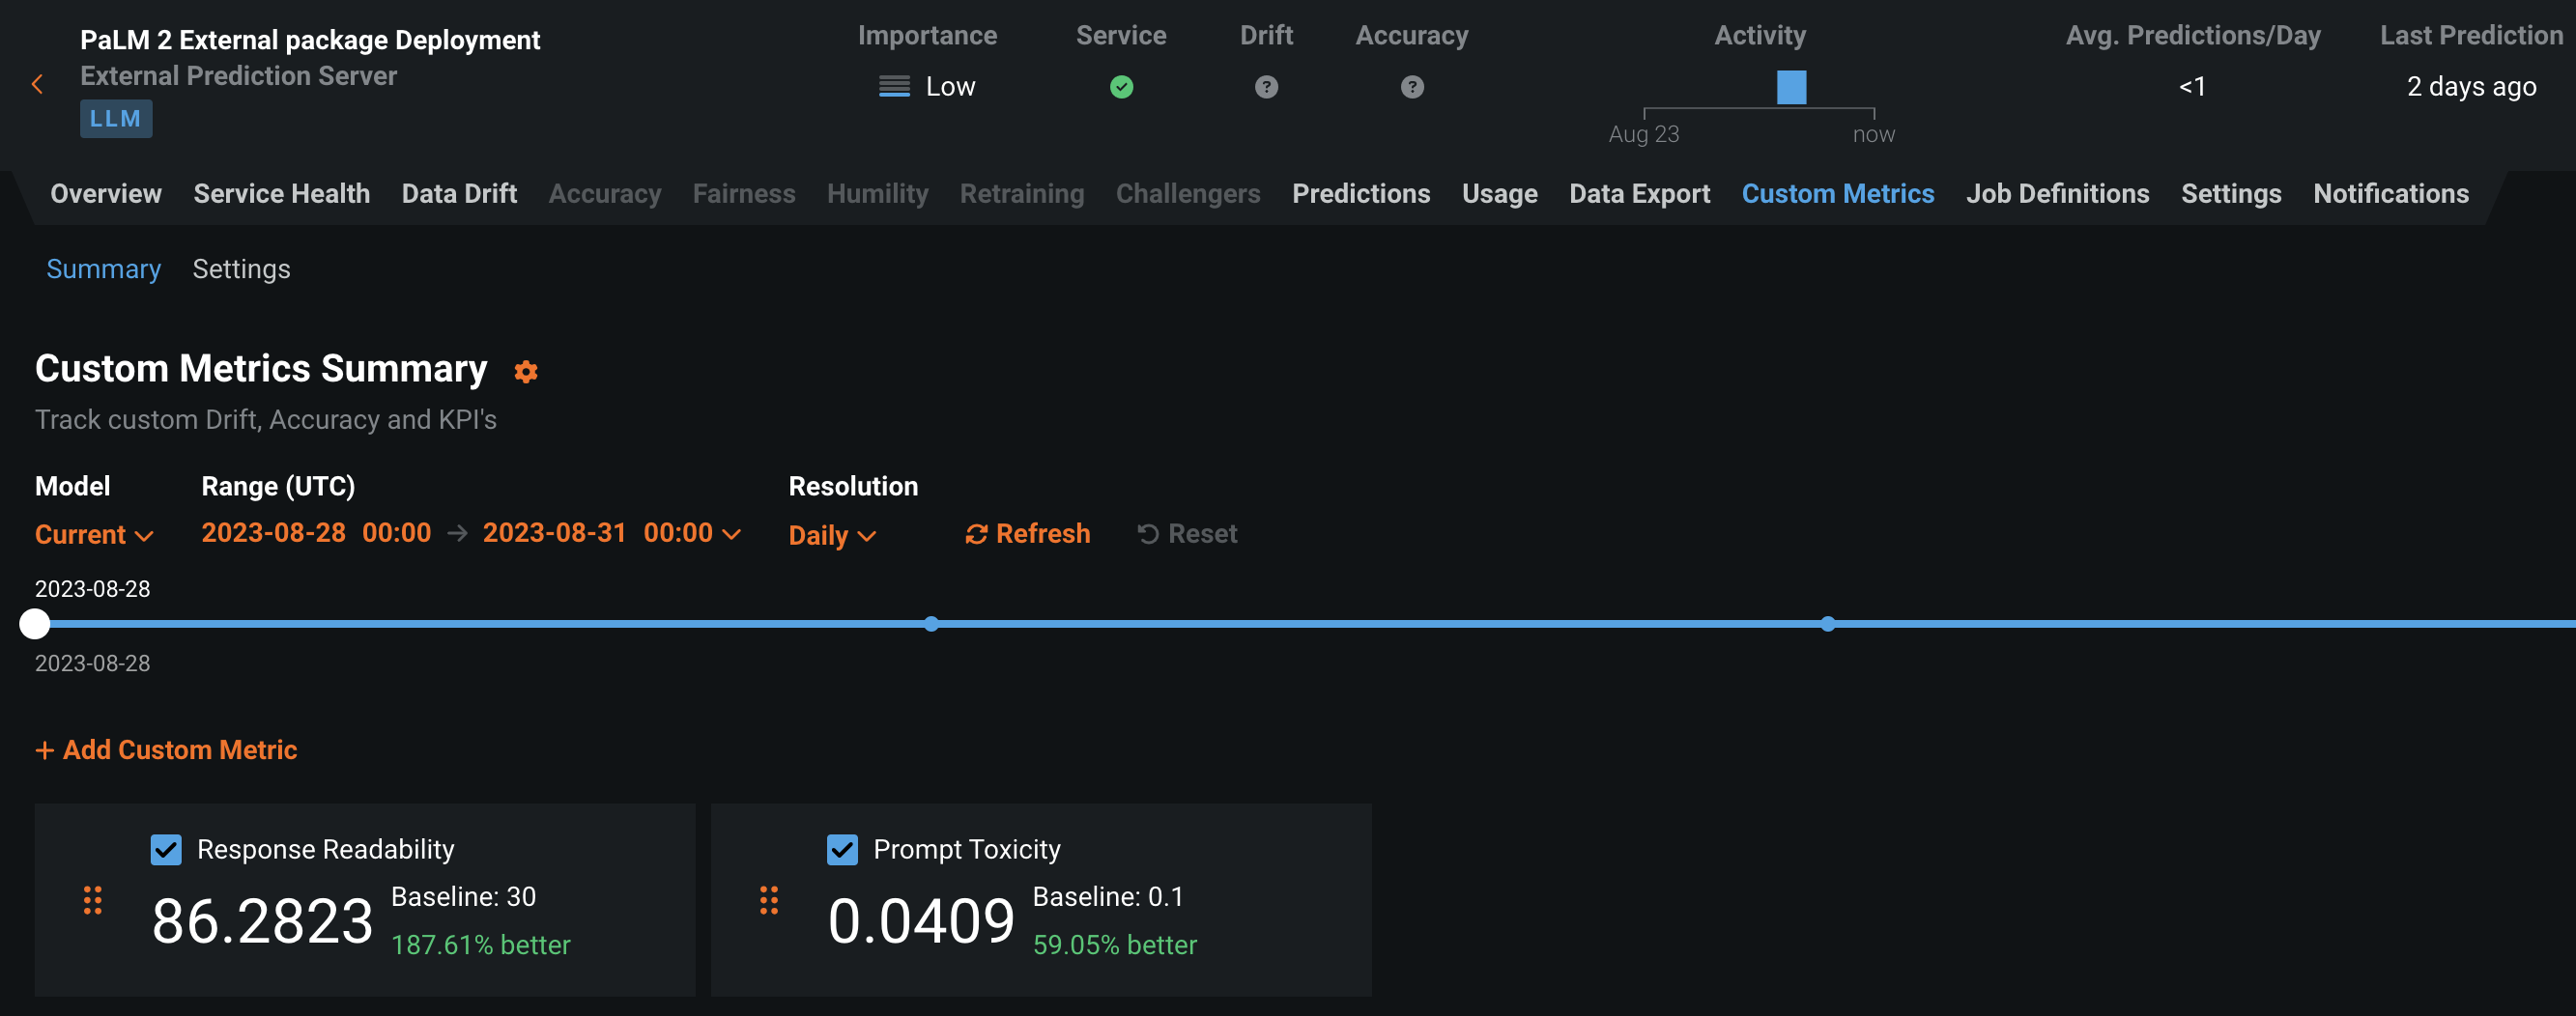

## Conclusion
Using DataRobot's tools for LLMOps, you can implement observability for PaLM 2-based applications easily with least friction and avoid increasing technical debt.